In [1]:
# imports 
import numpy as np
import pandas as pd
from math import sqrt 
from pprint import pprint
from numpy import array
from time import time

In [2]:
# load data
import constants
df = pd.read_csv("kddcup.data_10_percent.gz", names = constants.names)

In [3]:
# Categorical features to numeric labels

from sklearn import preprocessing
le_dicts = {}

for categorical_name in constants.categorical_names:
    le = preprocessing.LabelEncoder()
    le.fit(df[categorical_name])
    le_dicts[categorical_name] = dict(zip(le.transform(le.classes_), le.classes_))
    df[categorical_name + '_num'] = le.fit_transform(df[categorical_name])

df['cible'] = df.label.apply(lambda label: 1 if label == 'normal.' else 0)
df['label_four'] = df.label.apply(lambda label: constants.label_to_four_attack_class[label])
df['label_four_num'] = df.label_four.apply(lambda label: constants.five_classes_to_num[label])
df.drop(constants.categorical_names + ['label','label_four_num','label_four'], axis=1, inplace=True)
df.shape

(494021, 42)

In [4]:
# first 5
df.head()

duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        181       5450     0               0       0    0   
1         0        239        486     0               0       0    0   
2         0        235       1337     0               0       0    0   
3         0        219       1337     0               0       0    0   
4         0        217       2032     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...    \
0                  0          1                0  ...     
1                  0          1                0  ...     
2                  0          1                0  ...     
3                  0          1                0  ...     
4                  0          1                0  ...     

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.11                          0.0   
1                         0.05                          0.0   
2                         0.03                          0.0   
3                         0.03                          0.0   
4                         0.02                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                   0.0   
1                   0.0                       0.0                   0.0   
2                   0.0                       0.0                   0.0   
3                   0.0                       0.0                   0.0   
4                   0.0                       0.0                   0.0   

   dst_host_srv_rerror_rate  protocol_type_num  service_num  flag_num  cible  
0                       0.0                  1           22         9      1  
1                       0.0                  1           22         9      1  
2                       0.0                  1           22         9      1  
3                       0.0                  1           22         9      1  
4                       0.0                  1           22         9      1  

[5 rows x 42 columns]

In [5]:
# data to values
df = df.values

In [7]:
# DeepExtratTrees  
import argparse
import sys
import pickle
from sklearn.metrics import accuracy_score
sys.path.insert(0, "lib")
from gcforest.gcforest import GCForest
from gcforest.utils.config_utils import load_json
config = load_json("./examples/kdd.json")
gc = GCForest(config)

In [11]:
# train test 
from sklearn.cross_validation import train_test_split
y = df[:,41]
X = df[:,0:41]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
# count of class
len(np.unique(y_train))

2

In [13]:
             # X_enc is the concatenated predict_proba result of DeepExtratTrees

X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)
    

[ 2018-07-27 23:03:41,734][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 41)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 41)],y_test.shape=(163027,)
[ 2018-07-27 23:03:41,799][cascade_classifier.fit_transform] group_dims=[41]
[ 2018-07-27 23:03:41,800][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:03:41,801][cascade_classifier.fit_transform] group_ends=[41]
[ 2018-07-27 23:03:41,802][cascade_classifier.fit_transform] X_train.shape=(330994, 41),X_test.shape=(163027, 41)
[ 2018-07-27 23:03:41,874][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 41), X_cur_test.shape=(163027, 41)
[ 2018-07-27 23:03:47,989][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.97%
[ 2018-07-27 23:03:54,127][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-27 23:04:00,404][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

In [14]:
# predict
y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of DeepExtratTrees = {:.6f} %".format(acc * 100))

[ 2018-07-27 23:04:45,312][cascade_classifier.transform] X_groups_test.shape=[(163027, 41)]
[ 2018-07-27 23:04:45,334][cascade_classifier.transform] group_dims=[41]
[ 2018-07-27 23:04:45,335][cascade_classifier.transform] X_test.shape=(163027, 41)
[ 2018-07-27 23:04:45,356][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 41)


Test Accuracy of DeepExtratTrees = 99.976078 %


In [15]:
 # Matrix de confusion
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[130829     31]
 [     8  32159]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027



In [16]:
# Make data + estimators
X_test_enc = gc.transform(X_test)
X_train_enc = X_train_enc.reshape((X_train_enc.shape[0], -1))
X_test_enc = X_test_enc.reshape((X_test_enc.shape[0], -1))
X_train_origin = X_train.reshape((X_train.shape[0], -1))
X_test_origin = X_test.reshape((X_test.shape[0], -1))
X_train_enc = np.hstack((X_train_origin, X_train_enc))
X_test_enc = np.hstack((X_test_origin, X_test_enc))

[ 2018-07-27 23:04:49,271][cascade_classifier.transform] X_groups_test.shape=[(163027, 41)]
[ 2018-07-27 23:04:49,293][cascade_classifier.transform] group_dims=[41]
[ 2018-07-27 23:04:49,294][cascade_classifier.transform] X_test.shape=(163027, 41)
[ 2018-07-27 23:04:49,316][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 41)


In [17]:
X_train=X_train_enc
X_test=X_test_enc 
X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)

[ 2018-07-27 23:04:53,368][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:04:53,436][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:04:53,437][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:04:53,437][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:04:53,439][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:04:53,512][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:04:58,400][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-27 23:05:03,846][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-27 23:05:09,696][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

In [18]:
# predict  data + Es
y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of DeepExtratTrees = {:.6f} %".format(acc * 100))

[ 2018-07-27 23:05:48,855][cascade_classifier.transform] X_groups_test.shape=[(163027, 43)]
[ 2018-07-27 23:05:48,878][cascade_classifier.transform] group_dims=[43]
[ 2018-07-27 23:05:48,879][cascade_classifier.transform] X_test.shape=(163027, 43)
[ 2018-07-27 23:05:48,901][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 43)


Test Accuracy of DeepExtratTrees = 99.978531 %


In [19]:
 # Matrix de confusion
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[130841     19]
 [    16  32151]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027



In [20]:
def update(X_train,X_test):
    # update Estimators
    M = np.delete(X_train, (-1), axis=1)
    X_train= np.delete(M, (-1), axis=1)
    M = np.delete(X_test, (-1), axis=1)
    X_test = np.delete(M, (-1), axis=1)
    return X_train,X_test

def newdata(X_test_enc, X_train_enc):
    # Make Data + Estimators
    X_train_origin = X_train.reshape((X_train.shape[0], -1))
    X_test_origin = X_test.reshape((X_test.shape[0], -1))
    X_train_enc = np.hstack((X_train_origin, X_train_enc))
    X_test_enc = np.hstack((X_test_origin, X_test_enc))
    return X_test_enc, X_train_enc

Accuracy = []
def affiche():
    # predict
    y_pred = gc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Test Accuracy of DeepExtratTrees = {:.6f} %".format(acc * 100),"Layer :",i)
    Accuracy.append(round(acc*100 , 2))
    # Matrix de confusion
    from sklearn.metrics import classification_report, confusion_matrix
    print(confusion_matrix(y_test,y_pred))
    print('\n')
    print(classification_report(y_test,y_pred))
    
# Deep
t = []
for i in range (20):
    t0 = time()
    X_train,X_test=update(X_train,X_test)
    X_test_enc, X_train_enc=newdata(X_test_enc, X_train_enc)

    X_train=X_train_enc
    X_test=X_test_enc 
    X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)
    tt = time() - t0
    affiche() 
    t.append(round(tt,2))
    print (" Time ",format(round(tt,3))," seconds")

[ 2018-07-27 23:05:53,347][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:05:53,412][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:05:53,413][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:05:53,414][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:05:53,414][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:05:53,486][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:05:58,553][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-27 23:06:04,183][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-27 23:06:10,392][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.975464 %', 'Layer :', 0)
[[130840     20]
 [    20  32147]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '55.972', ' seconds')


[ 2018-07-27 23:06:53,377][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:06:53,442][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:06:53,443][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:06:53,444][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:06:53,445][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:06:53,518][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:06:58,614][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:07:04,361][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:07:10,598][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.975464 %', 'Layer :', 1)
[[130837     23]
 [    17  32150]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '56.368', ' seconds')


[ 2018-07-27 23:07:53,847][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:07:53,913][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:07:53,914][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:07:53,915][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:07:53,916][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:07:53,990][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:07:59,010][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:08:05,012][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-27 23:08:11,051][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.973624 %', 'Layer :', 2)
[[130833     27]
 [    16  32151]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '58.753', ' seconds')


[ 2018-07-27 23:08:56,703][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:08:56,770][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:08:56,771][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:08:56,772][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:08:56,773][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:08:56,846][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:09:02,095][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:09:08,293][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-27 23:09:14,134][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.974851 %', 'Layer :', 3)
[[130837     23]
 [    18  32149]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '57.623', ' seconds')


[ 2018-07-27 23:09:58,403][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:09:58,469][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:09:58,470][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:09:58,470][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:09:58,471][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:09:58,543][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:10:04,158][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:10:10,931][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-27 23:10:16,565][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.977304 %', 'Layer :', 4)
[[130838     22]
 [    15  32152]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '92.828', ' seconds')


[ 2018-07-27 23:11:40,275][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:11:40,416][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:11:40,433][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:11:40,437][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:11:40,442][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:11:40,609][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:11:51,443][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:12:03,323][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:12:16,243][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.977304 %', 'Layer :', 5)
[[130838     22]
 [    15  32152]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '111.452', ' seconds')


[ 2018-07-27 23:13:40,782][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:13:40,862][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:13:40,867][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:13:40,870][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:13:40,874][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:13:40,965][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:13:51,715][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:14:04,403][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-27 23:14:17,213][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.973624 %', 'Layer :', 6)
[[130840     20]
 [    23  32144]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '462.465', ' seconds')


[ 2018-07-27 23:21:33,298][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:21:33,415][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:21:33,417][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:21:33,418][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:21:33,419][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:21:33,595][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:21:44,789][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:21:56,059][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-27 23:22:06,633][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.971170 %', 'Layer :', 7)
[[130836     24]
 [    23  32144]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '112.053', ' seconds')


[ 2018-07-27 23:23:35,454][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:23:35,527][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:23:35,528][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:23:35,530][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:23:35,531][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:23:35,608][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:23:47,025][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:24:00,240][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:24:11,550][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.971170 %', 'Layer :', 8)
[[130833     27]
 [    20  32147]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '123.964', ' seconds')


[ 2018-07-27 23:25:46,204][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:25:46,270][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:25:46,271][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:25:46,272][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:25:46,273][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:25:46,347][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:25:56,900][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:26:09,880][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:26:20,943][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.971784 %', 'Layer :', 9)
[[130835     25]
 [    21  32146]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '129.8', ' seconds')


[ 2018-07-27 23:28:05,405][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:28:05,525][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:28:05,537][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:28:05,541][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:28:05,545][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:28:05,636][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:28:12,939][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:28:23,252][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.94%
[ 2018-07-27 23:28:34,341][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.972397 %', 'Layer :', 10)
[[130836     24]
 [    21  32146]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '112.324', ' seconds')


[ 2018-07-27 23:30:07,544][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:30:07,696][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:30:07,715][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:30:07,716][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:30:07,717][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:30:07,809][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:30:17,343][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:30:30,056][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.94%
[ 2018-07-27 23:30:42,365][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.972397 %', 'Layer :', 11)
[[130838     22]
 [    23  32144]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '122.614', ' seconds')


[ 2018-07-27 23:32:19,450][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:32:19,532][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:32:19,536][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:32:19,540][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:32:19,544][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:32:19,637][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:32:30,949][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-27 23:32:46,582][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:33:01,332][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.973624 %', 'Layer :', 12)
[[130838     22]
 [    21  32146]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '124.825', ' seconds')


[ 2018-07-27 23:34:33,684][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:34:33,772][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:34:33,777][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:34:33,781][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:34:33,785][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:34:33,879][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:34:45,715][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:34:55,783][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:35:07,865][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.971784 %', 'Layer :', 13)
[[130839     21]
 [    25  32142]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '121.194', ' seconds')


[ 2018-07-27 23:36:46,996][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:36:47,145][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:36:47,153][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:36:47,154][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:36:47,156][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:36:47,318][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:36:56,042][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:37:08,499][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:37:20,794][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.971784 %', 'Layer :', 14)
[[130837     23]
 [    23  32144]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '118.542', ' seconds')


[ 2018-07-27 23:38:57,494][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:38:57,579][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:38:57,581][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:38:57,582][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:38:57,583][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:38:57,675][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:39:06,136][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:39:17,075][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.94%
[ 2018-07-27 23:39:23,730][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.974237 %', 'Layer :', 15)
[[130841     19]
 [    23  32144]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '112.587', ' seconds')


[ 2018-07-27 23:41:00,156][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:41:00,285][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:41:00,294][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:41:00,298][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:41:00,302][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:41:00,488][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:41:09,120][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:41:22,641][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:41:33,064][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.976078 %', 'Layer :', 16)
[[130837     23]
 [    16  32151]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '121.976', ' seconds')


[ 2018-07-27 23:43:12,560][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:43:12,642][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:43:12,647][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:43:12,651][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:43:12,654][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:43:12,747][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:43:23,368][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:43:33,527][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:43:46,633][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.974851 %', 'Layer :', 17)
[[130840     20]
 [    21  32146]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '121.937', ' seconds')


[ 2018-07-27 23:45:24,096][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:45:24,244][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:45:24,248][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:45:24,252][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:45:24,256][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:45:24,351][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:45:34,270][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:45:42,011][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:45:55,505][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.976691 %', 'Layer :', 18)
[[130839     21]
 [    17  32150]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '123.45', ' seconds')


[ 2018-07-27 23:47:38,404][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-27 23:47:38,521][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-27 23:47:38,526][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 23:47:38,529][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-27 23:47:38,533][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-27 23:47:38,642][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-27 23:47:52,824][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-27 23:48:03,881][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-27 23:48:19,043][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

('Test Accuracy of DeepExtratTrees = 99.971784 %', 'Layer :', 19)
[[130834     26]
 [    20  32147]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '121.836', ' seconds')


('Opt_layer_num =', 0, ' Accuracy =', 99.98, 'Time =', 55.969999999999999)


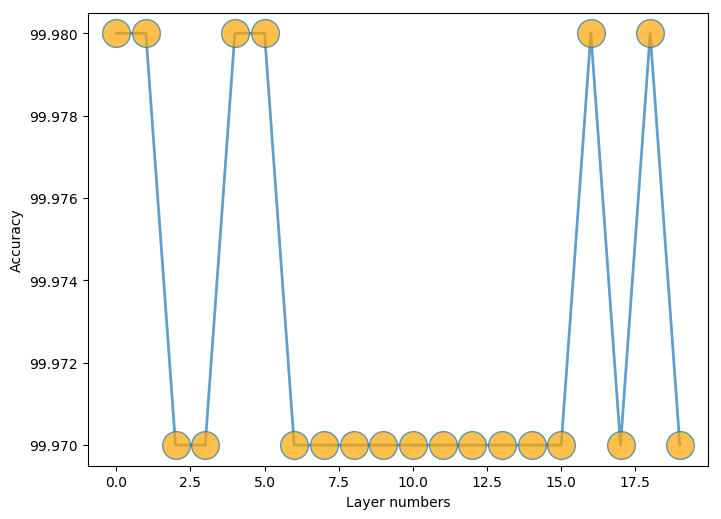

In [21]:
print ("Opt_layer_num =",Accuracy.index(max(Accuracy)), " Accuracy =", max(Accuracy) ,
       "Time =" , np.sum(t[0:Accuracy.index(max(Accuracy))+1]))

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
plt.plot(Accuracy, '-o', ms=20, lw=2, alpha=0.7, mfc='orange')
plt.ylabel('Accuracy')
plt.xlabel('Layer numbers')
plt.show()

In [22]:
Accuracy

[99.98,
 99.98,
 99.97,
 99.97,
 99.98,
 99.98,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.98,
 99.97,
 99.98,
 99.97]